In [ ]:
!pip install spacy
import spacy
!python -m spacy download ru_core_news_sm
nlp = spacy.load("ru_core_news_sm")

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import random
import json
import os.path, pandas as pd
import string
from collections import defaultdict, Counter
from collections import OrderedDict

In [ ]:
with open("book.json", "r", encoding='utf-8') as file:
    book_dict = json.load(file)

no_dialogs = [para for para in book_dict['2_Понтий Пилат'] if not para.startswith('–\xa0')]

In [ ]:
# папка с лемами глаголов
folder = '/lemmas'
dirs = os.listdir(folder)
verbs = {}
file_names = []
for file in dirs:
  file_names.append(file.split('.')[0].split('_')[-1])
  df = pd.read_excel('/'.join([folder, file]))
  verbs[file.split('lemmas')[-1].strip('_').replace('.xlsx', '')] = list(df.lemma)

In [ ]:
matrix = []
result = []
for par in no_dialogs:
  doc = nlp(par)
  inf_dict = {}
  paragraph_verbs = []
  for sent in doc.sents:

    verbs_sent = [token for token in sent if token.pos_ == 'VERB']
    verb_children = [[child for child in verb.children] for verb in verbs_sent]

    for i, childs in enumerate(verb_children):
      for ch in childs:
        if ch.lemma_ in ['прокуратор', 'пилат','понтий']:
          paragraph_verbs.append(verbs_sent[i].lemma_)
          child2see = childs

          for c in child2see:
            if c.pos_ == 'VERB':
              if len(list((Counter(['nsubj', 'iobj', 'dobj', "nsubj:pass", 'obj']) & Counter([i.dep_ for i in list(c.children)])).elements())) == 0:
                  paragraph_verbs.append(c.lemma_)
              else:
                for d in [i for i in list(c.children)]:
                  if d.dep_ not in ['nsubj', 'iobj', 'dobj', "nsubj:pass", 'obj'] and d.lemma_ in ['прокуратор', 'пилат','понтий']:
                    paragraph_verbs.append(c.lemma_)

  for v in verbs:
    common_items = list((Counter(paragraph_verbs) & Counter(verbs[v])).elements())
    inf_dict[v] = (len(common_items), common_items)

  sorted_dict = OrderedDict(sorted(inf_dict.items()))
  matrix.append([value[0] for value in inf_dict.values()])
  result.append([par,
                 paragraph_verbs,
                 sorted_dict])


In [ ]:
with open("chapter_2_verbs.json", "w", encoding='utf-8') as outfile:
    json.dump(result, outfile, ensure_ascii=False, indent=4)

In [ ]:
with open("chapter_2_verbs-2.json", "r", encoding='utf-8') as outfile:
    chapter2 = json.load(outfile)

In [ ]:
matrix = []
for inf in chapter2:
  matrix.append([value[0] for value in inf[2].values()])

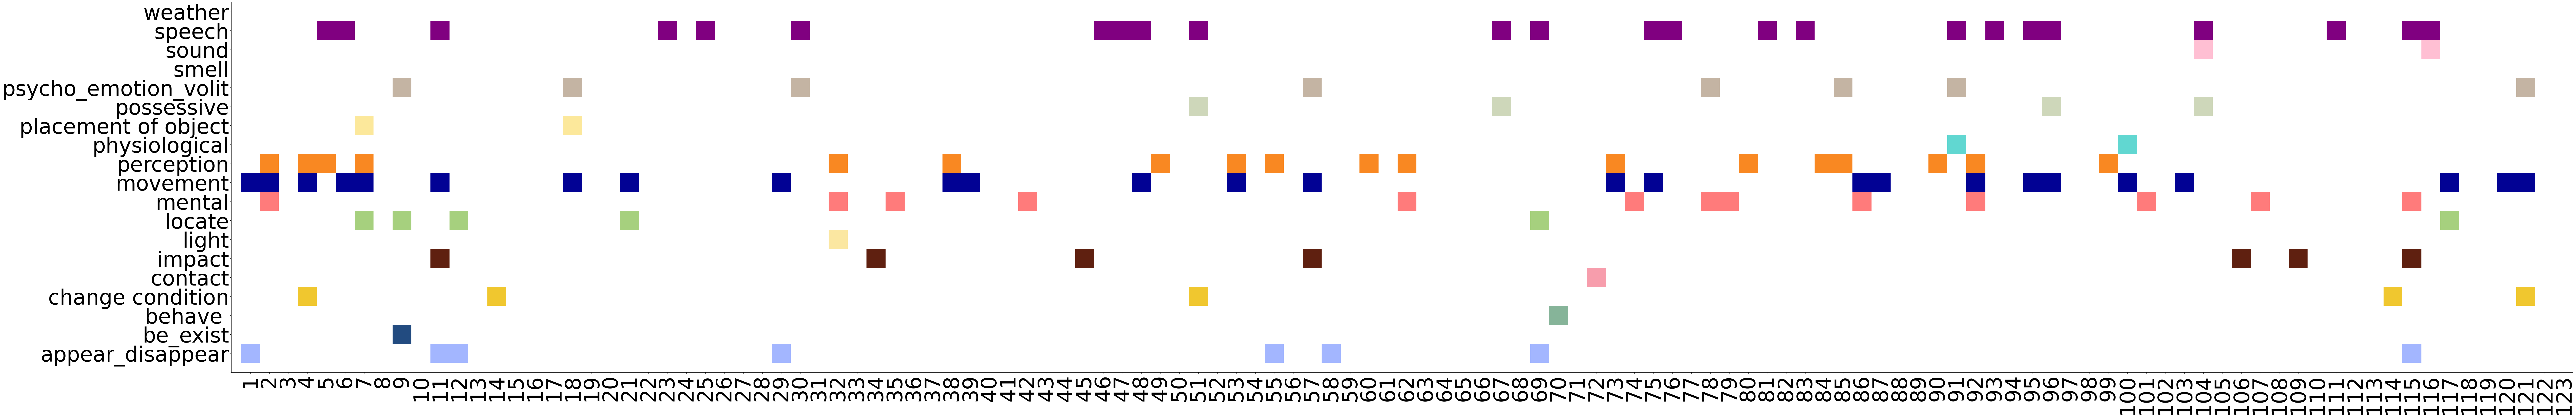

In [ ]:
arr = np.array(matrix).T

color_verbs = [
    '#a3b6ff', '#224b80', '#86b499', '#f0c72f', '#f79dac',
    '#5f2010', '#fbe7a1', '#a6d07e', '#ff7b7b', '#020294',
    '#f98822', '#61d7d1', '#fce89b', '#ced7ba', '#c4b4a3',
    '#ff00a9', '#ffbfd3', '#800080', '#dadae3'
]

row_labels = [
    'appear_disappear',
    'be_exist',
    'behave ',
    'change condition',
    'contact',
    'impact',
    'light',
    'locate',
    'mental',
    'movement',
    'perception',
    'physiological',
    'placement of object',
    'possessive',
    'psycho_emotion_volit',
    'smell',
    'sound',
    'speech',
    'weather'
]

fig, ax = plt.subplots(figsize=(130, 50))

for i in range(arr.shape[0]):
    for j in range(arr.shape[1]):
        color = color_verbs[i] if arr[i, j] == 1 else 'white'
        rect = plt.Rectangle((j, i), 1, 1, facecolor=color)
        ax.add_patch(rect)

# границы и масштаб
ax.set_xlim(0, arr.shape[1])
ax.set_ylim(0, arr.shape[0])
ax.set_aspect('equal')

ax.set_yticks(np.arange(len(row_labels)) + 0.5)
ax.set_yticklabels(row_labels, fontsize=65)

ax.set_xticks(np.arange(arr.shape[1]) + 0.5)
ax.set_xticklabels(np.arange(arr.shape[1]) + 1, fontsize=65, rotation=90)

ax.set_xticks(np.arange(arr.shape[1] + 1) - 0.5, minor=True)
ax.set_yticks(np.arange(arr.shape[0] + 1) - 0.5, minor=True)

plt.show()